<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import pandas as pd
import json
import scripts.scrape_gdpr_fines

In [2]:
# scripts.scrape_gdpr_fines.scrape_fines()

In [2]:
with open('data/scraped_fines.json', 'r', encoding='utf-8') as f:
    all_fines = json.load(f)

In [3]:
ungrouped = all_fines['allItems']
fines = pd.json_normalize(ungrouped)

In [4]:
text = pd.read_csv('data/gdpr_article_text.csv')

How are the fines distributed?

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
fines_nozero = fines.assign(price = lambda x: x.price+0.1)

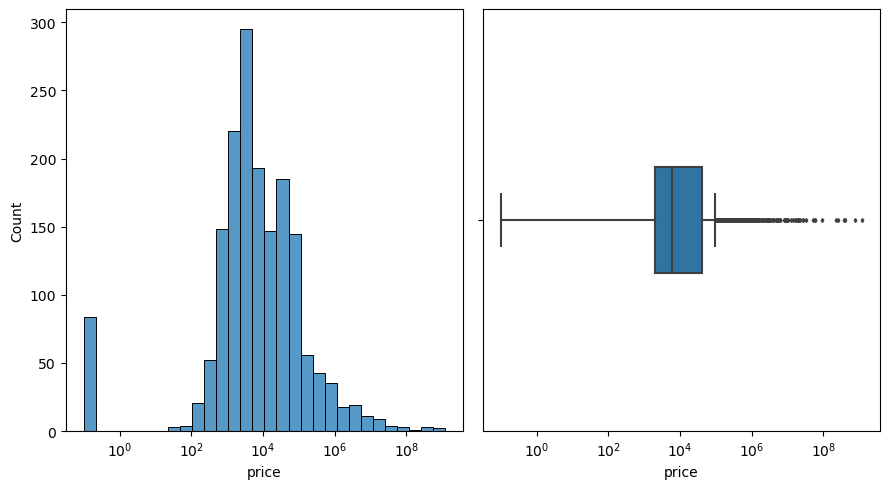

In [7]:
fig, ax = plt.subplots(1,2, figsize=(9, 5))
sns.histplot(data=fines_nozero, x="price", bins=30, log_scale=(True, False), ax=ax[0]);
sns.boxplot(data=fines_nozero, x="price", ax=ax[1], fliersize=2, width=0.25);

fig.axes[1].set_xscale('log')
fig.tight_layout()

gdpr_tidy <- gdpr_raw %>%
  transmute(id,
    price,
    country = name,
    article_violated,
    articles = str_extract_all(article_violated, "Art.[:digit:]+|Art. [:digit:]+")
  ) %>%
  mutate(total_articles = map_int(articles, length)) %>%
  unnest(articles) %>%
  add_count(articles) %>%
  filter(n > 10) %>%
  select(-n)

gdpr_tidy %>%
  mutate(
    articles = str_replace_all(articles, "Art. ", "Article "),
    articles = fct_reorder(articles, price)
  ) %>%
  ggplot(aes(articles, price + 1, color = articles, fill = articles)) +
  geom_boxplot(alpha = 0.2, outlier.colour = NA) +
  geom_quasirandom() +
  scale_y_log10(labels = scales::dollar_format(prefix = "€")) +
  labs(
    x = NULL, y = "GDPR fine (EUR)",
    title = "GDPR fines levied by article",
    subtitle = "For 250 violations in 25 countries"
  ) +
  theme(legend.position = "none")

In [9]:
fines_long = (
    fines
    .articleViolated.str.extractall(r'([Aa]rt. \d+(?=.*GDPR))')
    .reset_index()
    .rename(columns={'level_0':'id', 0:'article'})
    .assign(
        id = lambda x: x.id + 1,
        n_articles_violated = lambda x: (
            x
            .groupby('id')
            .match.transform('max')
            .astype('Int64') + 1
        ),
        article_number = lambda x: (
            x
            .article.str.extract(r'(\d+)')
            .astype('float')
            .astype('Int64')
        )
    )
    .merge(fines, how='right', left_on='id', right_on='id')
    .assign(date = lambda x: pd.to_datetime(x.date, format='%m/%d/%Y'))
    .loc[:, ['id', 'name', 'price', 'authority', 'date', 'controller','article',
             'article_number', 'n_articles_violated', 'type', 'summary']]
    .rename(columns={'price':'total_fine_euro', 'name': 'country'})
)

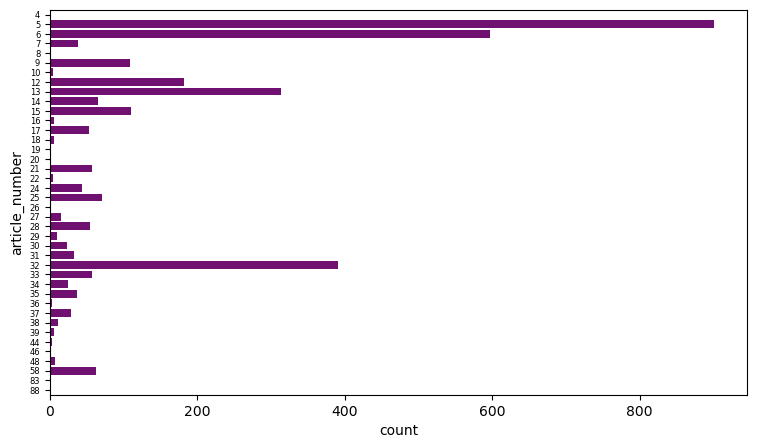

In [17]:
n_citations = (
    fines_long
    .value_counts('article_number')
    .reset_index(name='count')
    .sort_values('article_number')
)


fig, ax = plt.subplots(figsize = (9, 5))

sns.barplot(y='article_number', x='count', data=n_citations, orient='h', color='purple', ax=ax)
ax.tick_params(axis='y', which='major', labelsize=6)


gdpr_tidy %>%
  mutate(
    articles = str_replace_all(articles, "Art. ", ""),
    articles = fct_reorder(articles, price)
  ) %>%
  ggplot(aes(articles, price + 1, color = articles, fill = articles)) +
  geom_boxplot(alpha = 0.2, outlier.colour = NA) +
  geom_quasirandom() +
  scale_y_log10(labels = scales::dollar_format(prefix = "€")) +
  labs(
    x = NULL, y = "GDPR fine (EUR)",
    title = "GDPR fines levied by article",
    subtitle = "For 250 violations in 25 countries"
  ) +
  theme(legend.position = "none")

In [18]:
known_articles = (
    fines_long
    .query('total_fine_euro > 1')
    .sort_values('article_number')
    .dropna(subset='article_number')
)

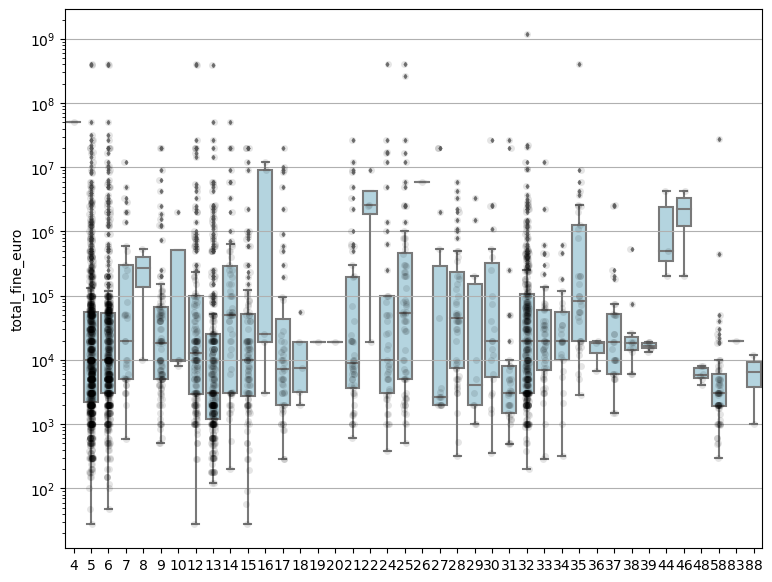

In [19]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_yscale("log")

sns.stripplot(
    x='article_number',
    y='total_fine_euro',
    data=known_articles,
    color='black',
    jitter=0.1,
    alpha=0.1
)
    
sns.boxplot(
    x='article_number',
    y='total_fine_euro',
    data=known_articles,
    color='lightblue',
    fliersize=2
)

ax.yaxis.grid(True)
ax.set(xlabel="");

In [20]:
top_n_highest_fines = (
    known_articles
    .groupby('article_number')
    .agg({'total_fine_euro': 'sum'})
    .reset_index()
    .sort_values('total_fine_euro', ascending=False)
    .head(10)
)

only_top_n_highest_fines = (
    known_articles
    .loc[known_articles.article_number.isin(top_n_highest_fines.article_number.tolist())]
)

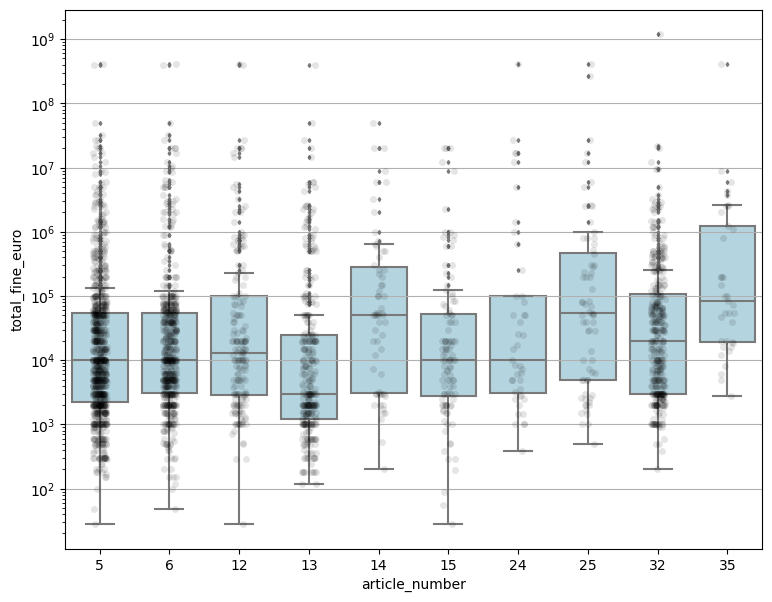

In [21]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_yscale("log")

sns.stripplot(
    x='article_number',
    y='total_fine_euro',
    data=only_top_n_highest_fines,
    color='black',
    jitter=0.1,
    alpha=0.1
)
    
sns.boxplot(
    x='article_number',
    y='total_fine_euro',
    data=only_top_n_highest_fines,
    color='lightblue',
    fliersize=2
)

ax.yaxis.grid(True)

gdpr_violations <- gdpr_tidy %>%
  mutate(value = 1) %>%
  select(-article_violated) %>%
  pivot_wider(
    names_from = articles, values_from = value,
    values_fn = list(value = max), values_fill = list(value = 0)
  ) %>%
  janitor::clean_names()

gdpr_violations

In [15]:
only_top_n_highest_fines.head(2)

,id,country,total_fine_euro,authority,date,controller,article,article_number,n_articles_violated,type,summary
2616,1297,Romania,5000,Romanian National Supervisory Authority for Pe...,2023-03-23,Tehnoplus Industry SRL,Art. 5,5,3,Failure to comply with data processing principles,The Romanian DPA has fined Tehnoplus Industry ...
1132,589,Italy,20000,Italian Data Protection Authority (Garante),2021-06-10,Dentist,Art. 5,5,1,Non-compliance with lawful basis for data proc...,The Italian DPA (also known as Garante) fined...


In [22]:
# pivot data
gdpr_model_data = (
    only_top_n_highest_fines
    .assign(violated=1, year = lambda x: x.date.dt.year, total_fine_euro = lambda x: np.log10(x.total_fine_euro))
    .loc[:, ['id','year', 'country', 'total_fine_euro', 'article_number', 'violated']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id', 'year', 'country', 'total_fine_euro', 'article_number'])
    .unstack(level=-1, fill_value=0)
)

In [23]:
# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['article_' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = gdpr_model_data.reset_index()

In [18]:
gdpr_model_data

,id,year,country,total_fine_euro,article_5,article_6,article_12,article_13,article_14,article_15,article_24,article_25,article_32,article_35
0,2,2019,Romania,3.397940,1,1,1,1,0,0,0,0,0,0
1,3,2019,Spain,4.778151,1,1,0,0,0,0,0,0,0,0
2,5,2019,Romania,5.176091,0,0,0,0,0,0,0,0,1,0
3,6,2019,Romania,4.301030,0,0,0,0,0,0,0,0,1,0
4,7,2019,Greece,5.301030,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,1695,2022,Greece,7.301030,1,1,1,0,1,1,0,0,0,0
1394,1698,2020,Malta,3.301030,0,0,0,0,0,0,0,0,1,0
1395,1699,2020,Malta,3.397940,1,0,0,0,0,0,0,0,1,0
1396,1700,2020,Malta,4.301030,0,0,0,1,0,1,0,0,0,0


<Axes: xlabel='year', ylabel='total_fine_euro'>

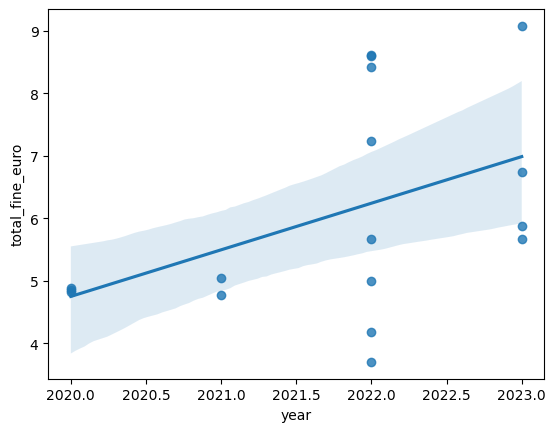

In [24]:
sns.regplot(x='year', y='total_fine_euro', data=gdpr_model_data.loc[gdpr_model_data.country == 'Ireland'])

In [25]:
fines_long.columns

Index(['id', 'country', 'total_fine_euro', 'authority', 'date', 'controller',
       'article', 'article_number', 'n_articles_violated', 'type', 'summary'],
      dtype='object')

In [27]:
top_25_fined_controllers = (
    fines_long
    .groupby('controller')
    .agg({'total_fine_euro':['sum', 'count', 'mean']})
    .droplevel(0, axis='columns')
    .reset_index()
    .sort_values('sum', ascending=False)
    .head(25)
)

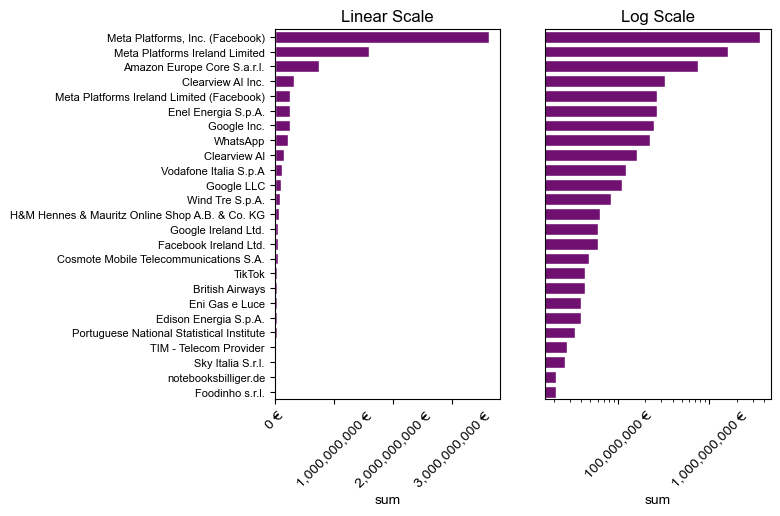

In [28]:
fig, ax = plt.subplots(1, 2)

sns.set_style('whitegrid')
sns.barplot(y='controller', x='sum', orient='h', data=top_25_fined_controllers, ax=ax[0], color='purple')
sns.barplot(y='controller', x='sum', orient='h', data=top_25_fined_controllers, ax=ax[1], color='purple')

fig.axes[0].set(title='Linear Scale', ylabel='')
ax[0].tick_params(axis="y", labelsize=8)
ax[0].xaxis.set_major_formatter('{x:,.0f} €')
ax[0].tick_params(axis='x', rotation=45)
fig.axes[1].set(xscale='log', ylabel='', yticklabels='', yticks=[], title='Log Scale')
ax[1].xaxis.set_major_formatter('{x:,.0f} €')
ax[1].tick_params(axis='x', rotation=45)

In [29]:
top_25_fined_controllers

,controller,sum,count,mean
723,"Meta Platforms, Inc. (Facebook)",3630000000,7,5.185714e+08
721,Meta Platforms Ireland Limited,1594000000,6,2.656667e+08
62,Amazon Europe Core S.a.r.l.,746000000,1,7.460000e+08
265,Clearview AI Inc.,330000000,22,1.500000e+07
722,Meta Platforms Ireland Limited (Facebook),265000000,1,2.650000e+08
419,Enel Energia S.p.A.,265000000,10,2.650000e+07
505,Google Inc.,250000000,5,5.000000e+07
1190,WhatsApp,225000000,1,2.250000e+08
266,Clearview Al,160000000,8,2.000000e+07
1169,Vodafone Italia S.p.A,122516010,10,1.225160e+07
